In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import zipfile
import os
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
!pip install -U kaleido
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 62.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
workspace = '/content/gdrive/MyDrive/DeepGC/NutriNet'

Mounted at /content/gdrive


In [ ]:
ZIP_PATH = workspace + "/Dataset/IndianFoodDataset.zip"
DATASET_PATH = "./IndianFoodDataset"
# Step 1: Extract the contents of the zip file
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(DATASET_PATH)

In [ ]:
!rm -rf ./IndianFoodDataset/.ipynb_checkpoints
!rm -rf ./IndianFoodDataset/Rajma
!rm -rf ./IndianFoodDataset/vada

In [ ]:
# Step 2: Load and preprocess the dataset
data_dir = DATASET_PATH

In [ ]:


def calculate_mean_and_std(dataset_path):
    transform = transforms.Compose([
        transforms.ToTensor(),  # Converts PIL Image to PyTorch tensor
    ])

    dataset = ImageFolder(root=dataset_path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    num_pixels = 0
    mean_acc = torch.zeros(3)  # Accumulator for mean values (assuming RGB images)
    std_acc = torch.zeros(3)   # Accumulator for standard deviation values (assuming RGB images)

    for images, _ in dataloader:
        batch_size, num_channels, height, width = images.size()
        num_pixels += batch_size * height * width

        # Flatten the images for each channel (RGB) and accumulate pixel values
        mean_acc += torch.sum(images.view(batch_size, num_channels, -1), dim=2).sum(dim=0)
        std_acc += torch.sum(images.view(batch_size, num_channels, -1) ** 2, dim=2).sum(dim=0)

    # Calculate mean and standard deviation
    mean = mean_acc / num_pixels
    std = torch.sqrt(std_acc / num_pixels - mean ** 2)

    return mean, std

# Example usage:
mean, std = calculate_mean_and_std(DATASET_PATH)
print("Mean:", mean)
print("Standard Deviation:", std)


Mean: tensor([0.6028, 0.5208, 0.4063])
Standard Deviation: tensor([0.2948, 0.2915, 0.3186])


In [ ]:
# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to a larger size
    transforms.RandomResizedCrop(224),  # Randomly crop the image and resize to (224, 224)
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(15),  # Randomly rotate the image by up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, saturation, and hue
    transforms.RandomPerspective(),  # Apply a random perspective transformation
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),  # Apply a random affine transformation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.6026, 0.5192, 0.4051], std=[0.2950, 0.2921, 0.3203])
])

# Load the dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Class names for Nutrition labeling
class_names = ['Indian bread - Naan', 'Chapati', 'Biryani', 'Uttapam', 'Paneer', 'Poha', 'Khichdi', 'Omelette',
               'Plain Rice', 'Dal Makhni', 'Dosa', 'Rajma', 'Poori', 'Chole', 'Dal', 'Sambhar', 'Papad', 'Gulab Jamun',
               'Idli', 'Vada', 'Chicken curry', 'Fish', 'potato curry', 'Okra curry', 'Green beans', 'curd']

# Perform train/validation split
train_size = int(0.8 * len(dataset))  # 80% for training
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

# Step 3: Define data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

# Step 4: Load the MobileNet model and modify the classifier
# model = models.mobilenet_v2(pretrained=True)
model = models.resnet50(pretrained=True)
num_classes = len(train_dataset.dataset.classes)

# # Freeze all the layers of the pre-trained model
# for param in model.parameters():
#     param.requires_grad = False

# Get the number of output features from the last layer of the MobileNet model
num_features = model.fc.in_features

# Add additional linear layers with dropout
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 255MB/s]


In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train(model, train_loader, criterion, optimizer, device, clip_gradient=None, regularization=None):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0
    all_labels = []
    all_predictions = []

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Apply regularization
        if regularization is not None:
            l2_reg = sum(torch.norm(p) ** 2 for p in model.parameters())
            loss += regularization * l2_reg

        loss.backward()

        # Apply gradient clipping
        if clip_gradient is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_gradient)

        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        train_accuracy += accuracy_score(labels.cpu().numpy(), predicted.cpu().numpy()) * images.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = train_accuracy / len(train_loader.dataset)
    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    return train_loss, train_accuracy


In [ ]:
def validate(model, valid_loader, criterion, device, dataset):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0.0
    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            valid_accuracy += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    valid_loss = valid_loss / len(valid_loader.dataset)
    valid_accuracy = valid_accuracy / len(valid_loader.dataset)
    precision = precision_score(all_labels, all_predictions, average='weighted',  zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted',  zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    # Calculate AUC scores for each class
    auc_scores = []
    for class_index in range(len(dataset.classes)):
        class_labels = np.array(all_labels) == class_index
        class_probabilities = np.array(all_probabilities)[:, class_index]
        if len(np.unique(class_labels)) == 1:  # Skip if all labels are the same class
            auc_scores.append(np.nan)
        else:
            auc = roc_auc_score(class_labels, class_probabilities)
            auc_scores.append(auc)

    return valid_loss, valid_accuracy, precision, recall, f1, auc_scores, all_predictions, all_labels


In [ ]:
# Step 5: Train the model
num_epochs = 30
learning_rate = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Load the checkpoint, if present
checkpoint = torch.load(workspace + '/model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []
precisions = []
recalls = []
f1_scores = []
auc_scores = []

# Save the trained checkpoint
checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'valid_losses': valid_losses,
    'train_accuracies': train_accuracies,
    'valid_accuracies': valid_accuracies,
    'precisions': precisions,
    'recalls': recalls,
    'f1_scores': f1_scores,
    'auc_scores': auc_scores,
}

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy, precision, recall, f1, auc, all_predictions, all_labels = validate(model, valid_loader, criterion, device, dataset)

    # Calculate class-wise precision, recall, and F1-score
    report = classification_report(all_labels, all_predictions, output_dict=True, zero_division=0)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    auc_scores.append(auc)

    torch.save(checkpoint, workspace + '/model_checkpoint.pth')
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# Print the classification report
print("Classification Report:")
print(report)

Epoch [1/30], Train Loss: 0.3873, Train Accuracy: 0.8814, Valid Loss: 0.7261, Valid Accuracy: 0.8026, Precision: 0.8065, Recall: 0.8026, F1-score: 0.8014
Epoch [2/30], Train Loss: 0.3576, Train Accuracy: 0.8871, Valid Loss: 0.7518, Valid Accuracy: 0.7877, Precision: 0.8045, Recall: 0.7877, F1-score: 0.7874
Epoch [3/30], Train Loss: 0.3791, Train Accuracy: 0.8865, Valid Loss: 0.8444, Valid Accuracy: 0.7747, Precision: 0.7925, Recall: 0.7747, F1-score: 0.7773
Epoch [4/30], Train Loss: 0.3958, Train Accuracy: 0.8777, Valid Loss: 0.8235, Valid Accuracy: 0.7697, Precision: 0.7837, Recall: 0.7697, F1-score: 0.7701
Epoch [5/30], Train Loss: 0.3687, Train Accuracy: 0.8882, Valid Loss: 0.8012, Valid Accuracy: 0.7778, Precision: 0.7839, Recall: 0.7778, F1-score: 0.7757
Epoch [6/30], Train Loss: 0.3623, Train Accuracy: 0.8854, Valid Loss: 0.7069, Valid Accuracy: 0.7927, Precision: 0.8008, Recall: 0.7927, F1-score: 0.7913
Epoch [7/30], Train Loss: 0.3363, Train Accuracy: 0.8966, Valid Loss: 0.7599

In [ ]:
# Save the trained model in ONNX format
input_width, input_height, input_channels = 224, 224, 3
input_sample = torch.randn(1, input_channels, input_height, input_width).to(device)  # Provide a sample input for the model
torch.onnx.export(model, input_sample, workspace + '/resnet50_indian_food_classification.onnx')

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [ ]:
# Print the classification report
# Class names for Nutrition labeling
class_names = ['Indian bread - Naan', 'Chapati', 'Biryani', 'Uttapam', 'Paneer', 'Poha', 'Khichdi', 'Omelette',
               'Plain Rice', 'Dal Makhni', 'Dosa', 'Poori', 'Chole', 'Dal', 'Sambhar', 'Papad', 'Gulab Jamun',
               'Idli', 'Chicken curry', 'Fish', 'potato curry', 'Okra curry', 'Green beans', 'curd']
print(class_names[10])
print(class_names[22])

print("Classification Report:")
for class_results in report.items():
  print(class_results)

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio

# Create the figure
fig = go.Figure()
# Add the train loss trace
fig.add_trace(go.Scatter(x=list(range(1, num_epochs + 1)), y=train_losses, mode='lines', name='Train Loss'))
# Add the validation loss trace
fig.add_trace(go.Scatter(x=list(range(1, num_epochs + 1)), y=valid_losses, mode='lines', name='Validation Loss'))
# Update the layout
fig.update_layout(title='Train and Validation Loss',
                  xaxis_title='Epochs',
                  yaxis_title='Loss')

# Show the plot
fig.show()


In [ ]:
# Plot the AUC curve
epochs = range(1, num_epochs+1)
plt.figure()
plt.plot(epochs, auc_scores, 'b-', label='AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.title('AUC Curve')
plt.legend()
plt.show()

In [ ]:
import plotly.express as px
import pandas as pd

# Create a dictionary to store the evaluation metrics
metrics = {
    'train_loss': train_losses,
    'train_accuracy': train_accuracies,
    'valid_loss': valid_losses,
    'valid_accuracy': valid_accuracies,
    'precision': precisions,
    'recall': recalls,
    'f1_score': f1_scores,
    'auc_score': auc_scores
}

# Convert the metrics dictionary to a pandas DataFrame
metrics_df = pd.DataFrame(metrics)

# Add the 'Epochs' column to the DataFrame
metrics_df['Epochs'] = epochs

# Melt the DataFrame to transform it into long format
metrics_melted = metrics_df.melt(id_vars='Epochs', var_name='Metric', value_name='Value')

# Plot the metrics using Plotly Express
fig = px.line(metrics_melted, x='Epochs', y='Value', color='Metric',
              title='Evaluation Metrics', labels={'Value': 'Metric Value'})

# Customize the layout
fig.update_layout(xaxis_title='Epochs', yaxis_title='Value', legend_title='Metric')

# Show the plot
fig.show()


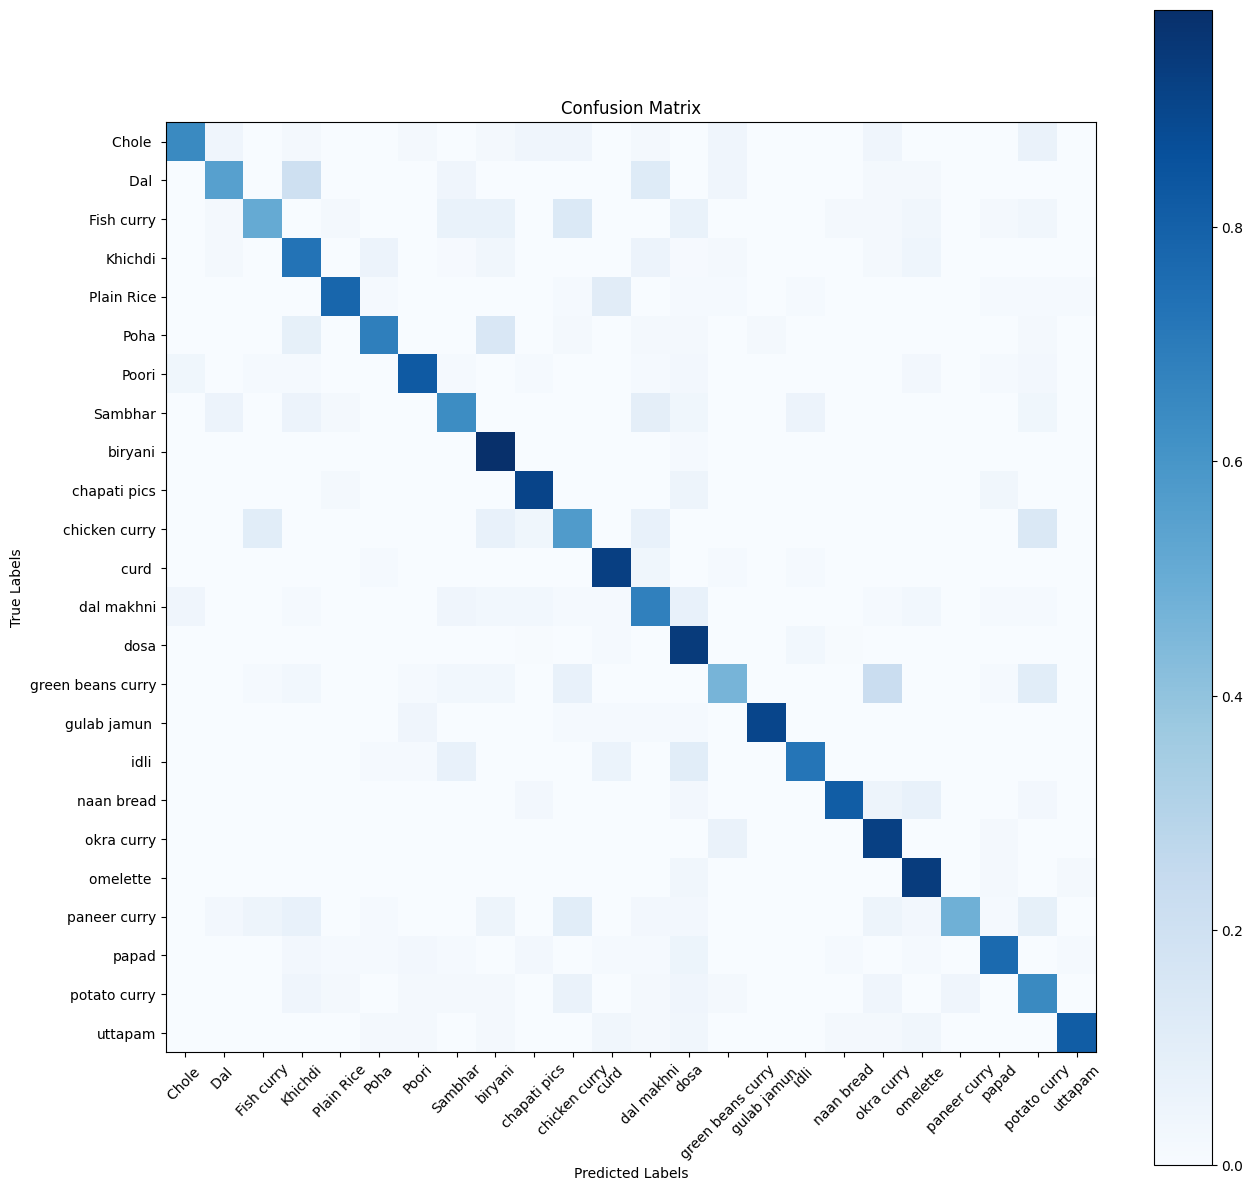

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(all_labels, all_predictions)
# Normalize the confusion matrix to [0, 1]
confusion_mat_norm = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]

# Step 5: Display the confusion matrix
plt.figure(figsize=(15, 15))
plt.imshow(confusion_mat_norm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.colorbar()
plt.xticks(np.arange(num_classes), dataset.classes, rotation=45)
plt.yticks(np.arange(num_classes), dataset.classes)
# Save the plot as a JPG image
plt.savefig('confusion_matrix.jpg', format='jpg', bbox_inches='tight')
plt.show()